<a href="https://colab.research.google.com/github/justincharney/Python_Machine_Learning/blob/main/Numpy_MLP_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code

In [ ]:
!pip install chainer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 14.1 MB/s 
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967740 sha256=ab1cd67943048d3d6dabcae248a78b4b3801fec9da1eeaa9e0b6825fba9c21ab
  Stored in directory: /root/.cache/pip/wheels/c5/01/d5/3ef194fa83dbf1d97bab826ca2bf235071f412861189a7b9df
Successfully built chainer


In [ ]:
!curl https://colab.chainer.org/install | sh -
import cupy as np
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1553  100  1553    0     0   6722      0 --:--:-- --:--:-- --:--:--  6722
********************************************************************************
CUDA version could not be detected!
Try installing Chainer manually by: pip install chainer
********************************************************************************


In [ ]:
from typing import List
from sklearn import datasets
from sklearn.utils import shuffle

In [ ]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# normalize training and testing images
train_images = train_images/255
test_images = test_images/255

In [ ]:
#categorical
train_y = np.eye(10)[train_labels]

In [ ]:
flattened_train_images = np.array([train_images[i,:,:].flatten() for i in range(len(train_images))])
flattened_test_images = np.array([test_images[i,:,:].flatten() for i in range(len(test_images))])

# Part 1 of Assignment 3 for COMP 551



## Multilayer Perceptron

In [ ]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

In [ ]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        np.random.seed(42)
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

In [ ]:
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
class LeakyReLULayer(NeuralNetLayer):
  def __init__(self):
    super().__init__()
  
  def forward(self, x, alpha=1e-5):
    self.gradient = np.where(x > 0, 1.0, alpha)
    return np.where(x > 0, x, x*alpha)
  
  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient * self.gradient

In [ ]:
class TanhLayer(NeuralNetLayer):
  def __init__(self):
        super().__init__()
        
  def forward(self, x):
        self.gradient = 1 - np.tanh(x)**2
        return np.tanh(x)

  def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
sigmoid = lambda x: 1/(1 + np.exp(-x))
class SigmoidLayer(NeuralNetLayer):
  def __init__(self):
        super().__init__()
        
  def forward(self, x):
        self.gradient = sigmoid(x)*(1-sigmoid(x))
        return sigmoid(x)

  def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        z = x - np.max(x, axis=-1, keepdims=True)
        numerator = np.exp(z)
        denominator = np.sum(numerator, axis=-1, keepdims=True)
        softmax = numerator / denominator
        self.cur_probs = softmax
        return softmax

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

In [ ]:
class MLP:
    def __init__(self, *args):
        self.layers = args

    def forward(self, x):
        for layer in self.layers[0]:
            x = layer.forward(x)
        return x

    def backward(self, target):
        derivatives = []
        for layer in self.layers[0][::-1]:
            target = layer.backward(target)
            derivatives.append(target)
        return derivatives
    
    def cost(self, x, y):
      out = self.forward(x)
      return -np.sum(y * np.log(out + 10**-100)).mean()
            
    def predict(self, x):
      return np.argmax(self.forward(x), axis=1)

In [ ]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self, wd):
        for layer in self.net.layers[0][::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient, wd)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient, wd):
        for (p, g) in zip(params, gradient):
          # added l2 norm weight decay term (for SGD we can reparameterize this to be l2 regularization)
          p -= self.lr * g.mean(axis=0) + self.lr * wd * p

In [ ]:
from tqdm import tqdm

def train(mlp: MLP, optimizer: Optimizer, data_x, data_y, test_x, test_y, epochs, batch_size=-1, wd=0, plot=False):
    losses = []
    test_accs = []
    train_accs = []
    np.random.seed(42) # to make mini-batch GD the same every time
    for _ in tqdm(range(epochs)):
      if batch_size == -1:
        predictions = mlp.forward(data_x)
        loss =  -np.sum(data_y * np.log(predictions + 10**-100))/predictions.shape[0] #-(data_y * 1e-9*np.log(predictions)).sum(axis=-1).mean()
        #print(loss)
        losses.append(loss)
        mlp.backward(data_y)
        optimizer.step(wd)
      else:
        rng = np.random.default_rng(seed=42)
        num_batches = int(np.ceil(np.divide(data_x.shape[0], batch_size)))
        xy = np.column_stack((data_x, data_y))
        #shuffle x and y
        np.random.shuffle(xy)
        for start in range(0, data_x.shape[0], batch_size):
          stop = start + batch_size
          x_batch, y_batch = xy[start:stop, :-10], xy[start:stop, -10:]
          predictions = mlp.forward(x_batch)
          loss =  -np.sum(y_batch * np.log(predictions + 10**-100)).mean() #/x_batch.shape[0]
          losses.append(loss)
          mlp.backward(y_batch)
          optimizer.step(wd)
      #EVAL AFTER EACH EPOCH
      test_preds = np.argmax(mlp.forward(test_x), axis=-1)
      test_acc = sum(test_preds==np.array(test_y))/len(test_preds)
      test_accs.append(test_acc)

      train_preds = np.argmax(mlp.forward(data_x), axis=-1)
      train_acc = sum(train_preds==np.argmax(data_y, axis=1))/len(train_preds)
      train_accs.append(train_acc)

    if plot:
      figure, axis = plt.subplots(2, 1)
      axis[1].plot(np.asnumpy(np.array(train_accs)), label="Train Acc")
      axis[1].plot(np.asnumpy(np.array(test_accs)), label="Test Acc")
      axis[1].set_ylabel("Accuracy", fontsize= 14)
      axis[1].legend(loc="upper left")
      axis[0].plot(np.asnumpy(np.array(losses)))
      axis[0].text(int(len(losses)*0.7), int(max(losses)/2), f"Last loss: {losses[-1].round(4)}", fontsize= 14)
      if batch_size == -1:
        axis[0].set_xlabel("Epoch", fontsize= 14)
        axis[1].set_xlabel("Epoch", fontsize= 14)
      else:
        axis[0].set_xlabel("Updates", fontsize= 14)
        axis[1].set_xlabel("Epoch", fontsize= 14)
      axis[0].set_ylabel("Cross entropy loss", fontsize= 14)
      plt.show()
    return losses

In [ ]:
import copy

def find_lr(mlp: MLP, optimizer: Optimizer, data_x, data_y, test_x, test_y, epochs, start_lr=-10, end_lr=1e-9, batch_size=10, wd=0):
  learning_rates = np.logspace(start_lr, end_lr, num=20).tolist()
  lr_losses = []
  max_delta_l = 10

  for lr in learning_rates:
    net = copy.deepcopy(mlp)
    opt = optimizer(net, lr)  # intialize the optimizer
    l = train(net, opt, data_x, data_y, test_x, test_y, epochs, batch_size=batch_size, wd=wd) # train for a few epochs and record loss
    lr_losses.append(float(np.array(l).mean())) # write the losses to a list to record all losses

  figure, axis = plt.subplots(2, 1)
  axis[0].plot(np.asnumpy(learning_rates), np.asnumpy(lr_losses))
  axis[0].set_title('Results for Learning Rate Range Test / Loss Values for Learning Rate')
  axis[0].set_xscale('log')
  axis[0].set_ylabel('loss')
  axis[0].set_xlabel('learning rate (log scale)')

  axis[1].plot(numpy.diff(np.asnumpy(learning_rates)), numpy.diff(np.asnumpy(lr_losses)))

  axis[1].set_xscale('log')
  axis[1].set_ylabel('derivative of loss')
  axis[1].set_xlabel('learning rate (log scale)')
  plt.show()


In [ ]:

def find_lr_wd(mlp: MLP, optimizer: Optimizer, data_x, data_y, test_x, test_y, epochs, start_lr=-7, end_lr=0, batch_size=10, wds=[1e-2, 1e-3, 1e-4, 1e-5]):
  wd_losses = []
  learning_rates = np.logspace(start_lr, end_lr, num=20).tolist()
  for wd in wds:
    lr_losses = []
    for lr in learning_rates:
      net = copy.deepcopy(mlp)
      opt = optimizer(net, lr)  # intialize the optimizer
      l = train(net, opt, data_x, data_y, test_x, test_y, epochs, batch_size=batch_size, wd=wd) # train for a few epochs and record loss
      lr_losses.append(float(np.array(l).mean())) # write the losses to a list to record all losses
    wd_losses.append(lr_losses)
  
  figure, axis = plt.subplots(2, 1)
  for i, ls in enumerate(wd_losses):
    axis[0].plot(np.asnumpy(learning_rates), np.asnumpy(ls), label=str(wds[i]))
    axis[0].legend(loc="upper left")
    axis[1].plot(numpy.diff(np.asnumpy(learning_rates)), numpy.diff(np.asnumpy(ls)), label=str(wds[i]))
    axis[1].legend(loc="upper left")
  axis[0].set_title('Results for Learning Rate Range Test / Loss Values for Learning Rate with Weight Decay')
  axis[0].set_xscale('log')
  axis[0].set_ylabel('loss')
  axis[0].set_xlabel('learning rate (log scale)')

  axis[1].set_xscale('log')
  axis[1].set_ylabel('derivative of loss')
  axis[1].set_xlabel('learning rate (log scale)')
  plt.show()

# Checking Gradients (for a linear layer)

This code was written to check the gradients for a linear layer in a one layer MLP.

---



In [ ]:
# creation of an example MLP
mlp = MLP(
    [LinearLayer(2,2)]
)
opt = GradientDescentOptimizer(mlp, 1e-3)
x = numpy.array([[0.25,0.5],[0.75,1]])
y = numpy.array([[1,0],[0,1]])

train(mlp, opt, np.array(x), np.array(y), np.array(x), np.array(y), epochs=10)
out = mlp.forward(np.array(x))
grad = mlp.backward(np.array(y))
print(mlp.layers[0][0].parameters)
print(grad[0].shape) # 2 weights and 2 biases)

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

[array([[-0.27103421, -1.06179843],
       [-0.70129877, -0.72817051]]), array([1.32091744, 0.00896816])]
(2, 2)


In [ ]:
import random
def check_gradient(mpl, x, y, h=1e-6, diff_tolerance=1e-5):
    for l, layer in enumerate(mlp.layers[0]):
      layer0 = copy.deepcopy(layer)
      layer1 = copy.deepcopy(layer)
      layer2 = copy.deepcopy(layer)
      rndstate = random.getstate()
      random.setstate(rndstate)

      mlp.forward(np.array(x, 'd'))
      grad = layer0.backward(np.array(y,'d'))  # Evaluate function value at original point)
      layer_shape= layer0.parameters[0].shape

      for i in tqdm(range(layer_shape[0])):
        for j in range(layer_shape[1]):

          random.setstate(rndstate)
          xp = copy.deepcopy(x)
          xp[i,j] += h
          fxp= layer1.forward(np.array(xp, 'd')).get() #f(xp)

          random.setstate(rndstate)
          xn = copy.deepcopy(x)
          xn[i,j] -= h
          fxn = layer2.forward(np.array(xn, 'd')).get() #f(xn)
          #calculate numerical gradient
          numgrad = (fxp[i,i]-fxn[i,i]) / (2*h)
        
        # Compare gradients
          reldiff = abs(numgrad - grad[i,j].get()) / max(1, abs(numgrad), abs(grad[i,j].get()))
          if reldiff > diff_tolerance:
            print ("Gradient check failed.")
            print ("First gradient error found at index %s" % str((i,j)))
            print (f"Your gradient:{grad[i,j]}\n Numerical gradient: {numgrad}")
            return

        #it.iternext() # Step to next dimension

    print ("Gradient check passed!")

In [ ]:
check_gradient(mlp, x, y)

100%|██████████| 2/2 [00:00<00:00, 277.38it/s]

Gradient check passed!


#Part 3: Experiments

###MLP with no hidden layer this the same as a multi-class perceptron or multiple-regression in A2

In [ ]:
#GRADIENT_STEPS = 200

mlp0 = MLP(
    [LinearLayer(784, 10),
    SoftmaxOutputLayer()]
)

100%|██████████| 5/5 [00:00<00:00,  9.82it/s]


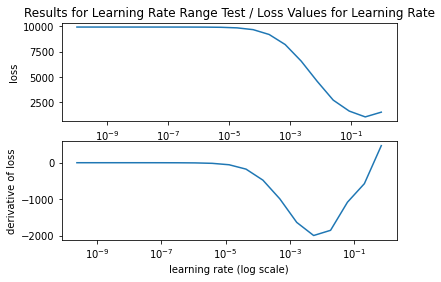

In [ ]:
# find LR
find_lr(mlp0, GradientDescentOptimizer, flattened_train_images, train_y, flattened_test_images, test_labels, epochs=5, batch_size=600)

100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


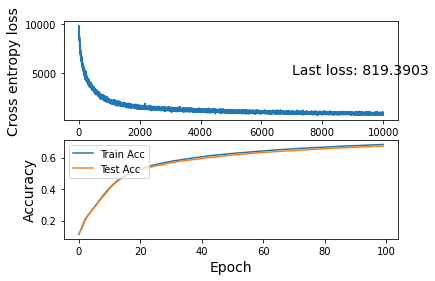

In [ ]:
GRADIENT_STEPS = 100

mlp0 = MLP(
    [LinearLayer(784, 10),
    SoftmaxOutputLayer()]
)

opt0 = GradientDescentOptimizer(mlp0, 6e-3)

loss0 = train(mlp0, opt0, flattened_train_images, train_y, flattened_test_images, test_labels, GRADIENT_STEPS, batch_size=600, plot=True)

In [ ]:
# testing accuracy
predictions = mlp0.predict(flattened_test_images)
print(f"Accuracy: {sum(predictions==np.array(test_labels) )/len(predictions)}")

Accuracy: 0.673


###MLP with 1 hidden layer of 128 units and ReLU activation function

In [ ]:
# testing using our data
HIDDEN_SIZE = 128
GRADIENT_STEPS = 100

mlp1 = MLP(
    [LinearLayer(784, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()]
)

100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


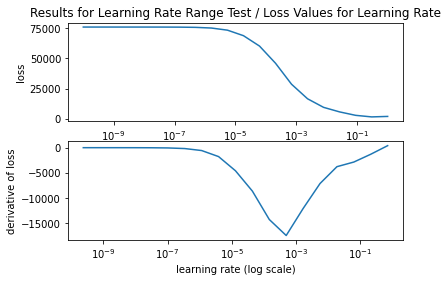

In [ ]:
#find_lr
find_lr(mlp1, GradientDescentOptimizer, flattened_train_images, train_y, flattened_test_images, test_labels, epochs=5, batch_size=600)

100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


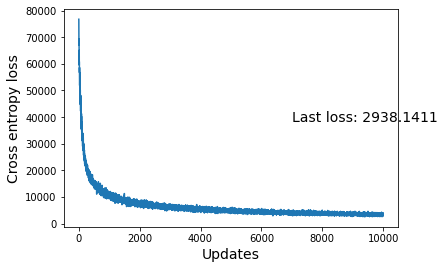

In [ ]:
# testing using our data
HIDDEN_SIZE = 128
GRADIENT_STEPS = 100

mlp1 = MLP(
    [LinearLayer(784, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()]
)
opt1 = GradientDescentOptimizer(mlp1, 8e-4)
losses_1 = train(mlp1, opt1, flattened_train_images, train_y, flattened_test_images, test_labels, GRADIENT_STEPS, batch_size=600, plot=True)

In [ ]:
# testing accuracy
predictions = mlp1.predict(flattened_test_images)
print(f"Accuracy: {sum(predictions==np.array(test_labels))/len(predictions)}")

Accuracy: 0.7118


###MLP with 2 layers each having 128 units and relu activations

In [ ]:
HIDDEN_SIZE=128
#GRADIENT_STEPS = 10

mlp2 = MLP(
    [LinearLayer(784, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()]
)

100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


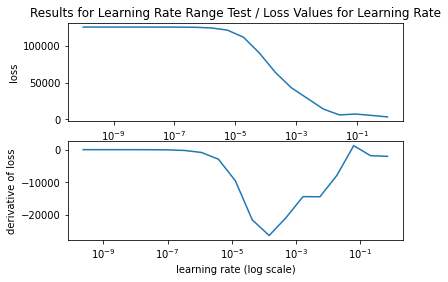

In [ ]:
#find_lr
find_lr(mlp2, GradientDescentOptimizer, flattened_train_images, train_y, flattened_test_images, test_labels, epochs=5, batch_size=600)

100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


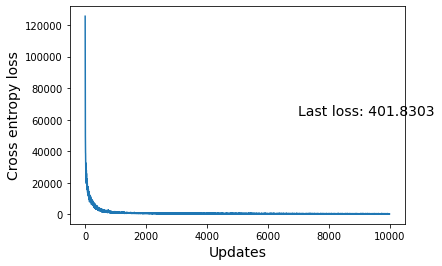

In [ ]:
HIDDEN_SIZE = 128
GRADIENT_STEPS = 100

mlp2 = MLP(
    LinearLayer(784, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)

opt2 = GradientDescentOptimizer(mlp2, 1e-2)
losses_2 = train(mlp2, opt2, flattened_train_images, train_y, flattened_test_images, test_labels, GRADIENT_STEPS, batch_size=600, plot=True)

In [ ]:
predictions = mlp2.predict(flattened_test_images)
print(f"Accuracy: {sum(predictions==np.array(test_labels))/len(predictions)}")

Accuracy: 0.732


###MLP with 2 layers each having 128 units and tanh activations

In [ ]:
HIDDEN_SIZE=128

mlp3 = MLP(
    [LinearLayer(784, HIDDEN_SIZE),
    TanhLayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    TanhLayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()]
)

100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


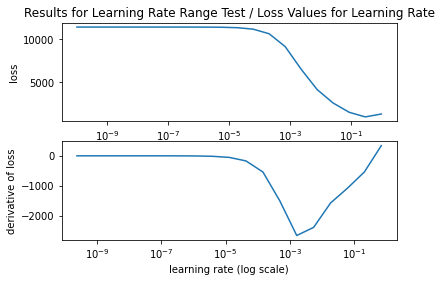

In [ ]:
# find lr
find_lr(mlp3, GradientDescentOptimizer, flattened_train_images, train_y, flattened_test_images, test_labels, epochs=5, batch_size=600)

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


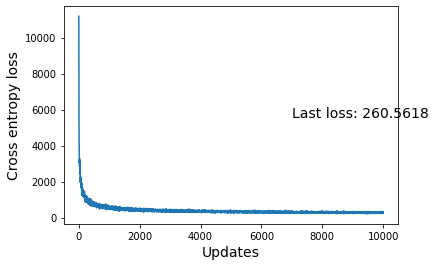

In [ ]:
HIDDEN_SIZE=128
GRADIENT_STEPS = 100

mlp3 = MLP(
    [LinearLayer(784, HIDDEN_SIZE),
    TanhLayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    TanhLayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()]
)
opt3 = GradientDescentOptimizer(mlp3, 1e-1)
losses_3 = train(mlp3, opt3, flattened_train_images, train_y, flattened_test_images, test_labels, GRADIENT_STEPS, batch_size=600, plot=True)

In [ ]:
predictions = mlp3.predict(flattened_test_images)
print(f"Accuracy: {sum(predictions==np.array(test_labels))/len(predictions)}")

Accuracy: 0.7785


###MLP with 2 layers each having 128 units and leaky-relu activations

In [ ]:
HIDDEN_SIZE=128

mlp4 = MLP(
    [LinearLayer(784, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()]
)

100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


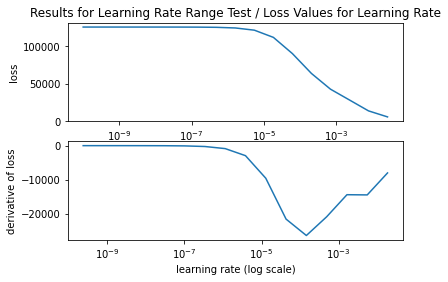

In [ ]:
# find lr
find_lr(mlp4, GradientDescentOptimizer, flattened_train_images, train_y, flattened_test_images, test_labels, epochs=5, batch_size=600)

100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


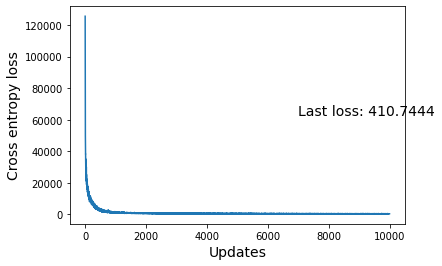

In [ ]:
HIDDEN_SIZE=128
GRADIENT_STEPS = 100

mlp4 = MLP(
    [LinearLayer(784, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()]
)

opt4 = GradientDescentOptimizer(mlp4, 1e-2)
losses_4 = train(mlp4, opt4, flattened_train_images, train_y, flattened_test_images, test_labels, GRADIENT_STEPS, batch_size=600, plot=True)

In [ ]:
predictions = mlp4.predict(flattened_test_images)
print(f"Accuracy: {sum(predictions==np.array(test_labels))/len(predictions)}")

Accuracy: 0.7311


### 2 layer MLP with relu and l2 normalization

In [ ]:
HIDDEN_SIZE=128

mlp5 = MLP(
    [LinearLayer(784, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()]
)

100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


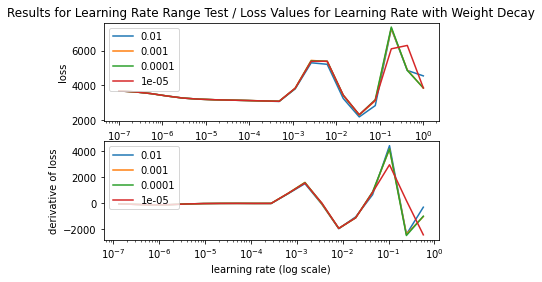

In [ ]:
# find wd
find_lr_wd(mlp5, GradientDescentOptimizer, flattened_train_images, train_y, flattened_test_images, test_labels, epochs=5, batch_size=600)

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


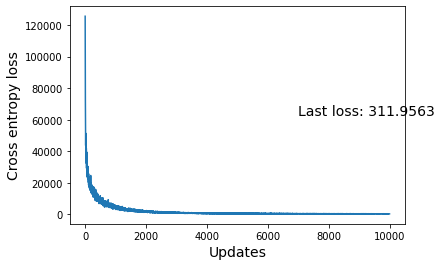

In [ ]:
HIDDEN_SIZE=128
GRADIENT_STEPS = 100

mlp5 = MLP(
    [LinearLayer(784, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()]
)

opt5 = GradientDescentOptimizer(mlp5, 5e-3)
losses_5 = train(mlp5, opt5, flattened_train_images, train_y, flattened_test_images, test_labels, GRADIENT_STEPS, batch_size=600, plot=True, wd=1e-2)

In [ ]:
predictions = mlp5.predict(flattened_test_images)
print(f"Accuracy: {sum(predictions==np.array(test_labels))/len(predictions)}")

Accuracy: 0.7819


### MLP with 2 layers and ReLU but unormalized images

In [ ]:
train_images_un = train_images * 255
test_images_un = test_images * 255

flattened_train_images_un = np.array([train_images_un[i,:,:].flatten() for i in range(len(train_images_un))])
flattened_test_images_un = np.array([test_images_un[i,:,:].flatten() for i in range(len(test_images_un))])

In [ ]:
train_y = np.array(train_y)

In [ ]:
HIDDEN_SIZE = 128
GRADIENT_STEPS = 100

mlp6 = MLP(
    [LinearLayer(784, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()]
)

100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


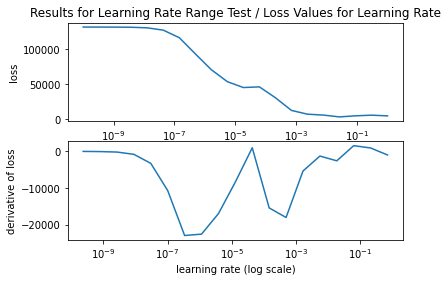

In [ ]:
# find lr
find_lr(mlp6, GradientDescentOptimizer, flattened_train_images_un, train_y, flattened_test_images_un, test_labels, epochs=5, batch_size=600)

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


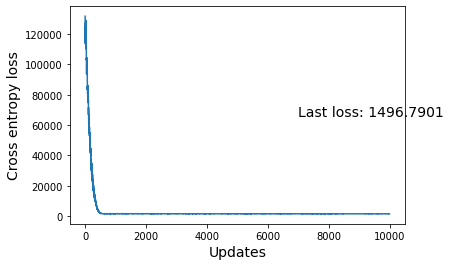

In [ ]:
HIDDEN_SIZE = 128
GRADIENT_STEPS = 100

mlp6 = MLP(
    [LinearLayer(784, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()]
)

opt6 = GradientDescentOptimizer(mlp6, 3e-4)
losses_6 = train(mlp6, opt6, flattened_train_images_un, train_y, flattened_test_images_un, test_labels, GRADIENT_STEPS, batch_size=600, plot=True)

In [ ]:
predictions = mlp6.predict(flattened_test_images_un)
print(f"Accuracy: {sum(predictions==np.array(test_labels))/len(predictions)}")

Accuracy: 0.1


#MLP Hyperparameter Tuning

In [ ]:
!pip install optuna -q

     |████████████████████████████████| 348 kB 35.6 MB/s 
     |████████████████████████████████| 81 kB 11.6 MB/s 
     |████████████████████████████████| 209 kB 69.7 MB/s 
     |████████████████████████████████| 78 kB 8.6 MB/s 
     |████████████████████████████████| 50 kB 5.0 MB/s 
     |████████████████████████████████| 147 kB 72.2 MB/s 
     |████████████████████████████████| 112 kB 68.4 MB/s 


In [ ]:
import optuna

def model(trial):
  n_layers = trial.suggest_int("n_layers", 2, 4)
  layers = []

  in_features = 784
  for i in range(n_layers):
    # Suggest the number of units in each layer
    out_features = trial.suggest_categorical("n_units_l{}".format(i), [128, 256])
    layers.append(LinearLayer(in_features, out_features))
    layers.append(TanhLayer())

    in_features = out_features
  
  layers.append(LinearLayer(in_features, 10))
  layers.append(SoftmaxOutputLayer())

  mlp = MLP(layers)
  return mlp


In [ ]:
def hyperparameters(trial, model):
  lr = trial.suggest_float("learning_rate", 1e-5, 9e-1)
  wd = trial.suggest_float('regularization', 1e-5, 1e-1)
  opt = GradientDescentOptimizer(model, lr)

  return wd, opt

In [ ]:
def train_and_eval(model, optimizer, train_x, train_y, test_x, test_y, epochs, wd, trial, batch_size=600):
  #TRAIN
  for epoch in range(epochs):
    num_batches = int(np.ceil(np.divide(train_x.shape[0], batch_size)))
    xy = np.column_stack((train_x, train_y))
    #shuffle x and y
    np.random.shuffle(xy)
    for start in range(0, train_x.shape[0], batch_size):
      stop = start + batch_size
      x_batch, y_batch = xy[start:stop, :-10], xy[start:stop, -10:]
      predictions = model.forward(x_batch)
      loss =  -np.sum(y_batch * np.log(predictions + 10**-100)).mean() #/x_batch.shape[0]
      model.backward(y_batch)
      optimizer.step(wd)

    #EVAL AFTER EACH EPOCH
    preds = np.argmax(model.forward(test_x), axis=1)
    acc = sum(preds==np.array(test_y))/len(preds)
    
    trial.report(acc, epoch)
    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()
  
  return acc

In [ ]:
def objective(trial):

  m = model(trial)

  wd, opt = hyperparameters(trial, m)

  acc = train_and_eval(m, opt, flattened_train_images, train_y,
                       flattened_test_images, np.array(test_labels), 50,
                       wd, trial)
  return acc

In [ ]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30)

[I 2022-12-05 02:41:55,655] A new study created in memory with name: no-name-ecbd8bcd-872e-4e96-b256-31c18c412c77
[I 2022-12-05 02:43:23,808] Trial 0 finished with value: 0.7055 and parameters: {'n_layers': 4, 'n_units_l0': 128, 'n_units_l1': 128, 'n_units_l2': 256, 'n_units_l3': 256, 'learning_rate': 0.01885337953387646, 'regularization': 0.005626888557767642}. Best is trial 0 with value: 0.7055.
[I 2022-12-05 02:45:13,898] Trial 1 finished with value: 0.8202 and parameters: {'n_layers': 4, 'n_units_l0': 256, 'n_units_l1': 128, 'n_units_l2': 128, 'n_units_l3': 256, 'learning_rate': 0.3028010290444339, 'regularization': 0.003924862511418764}. Best is trial 1 with value: 0.8202.
[I 2022-12-05 02:47:03,669] Trial 2 finished with value: 0.1 and parameters: {'n_layers': 4, 'n_units_l0': 256, 'n_units_l1': 128, 'n_units_l2': 128, 'n_units_l3': 256, 'learning_rate': 0.6336193769505752, 'regularization': 0.09582508731414639}. Best is trial 1 with value: 0.8202.
[I 2022-12-05 02:48:19,764] Tri

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

n_layers: 2
n_units_l0: 256
n_units_l1: 256
learning_rate: 0.5102002641004556
regularization: 0.0008630881450338093


In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

###Train Optimized MLP

100%|██████████| 100/100 [05:30<00:00,  3.30s/it]


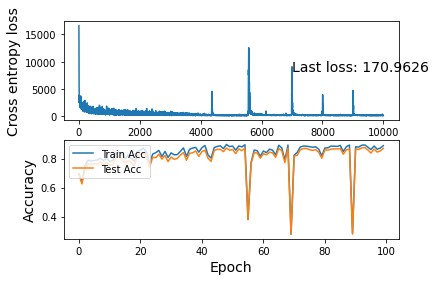

In [ ]:
HIDDEN_SIZE=256
GRADIENT_STEPS = 100

mlp_f = MLP(
    [LinearLayer(784, HIDDEN_SIZE),
    TanhLayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    TanhLayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()]
)

opt_f = GradientDescentOptimizer(mlp_f, 0.5102002641004556)
losses_f = train(mlp_f, opt_f, flattened_train_images, np.array(train_y), flattened_test_images, np.array(test_labels), GRADIENT_STEPS, batch_size=600, plot=True, wd=0.0008630881450338093)

In [ ]:
predictions = mlp_f.predict(flattened_test_images)
print(f"Accuracy: {sum(predictions==np.array(test_labels))/len(predictions)}")

Accuracy: 0.87


#CNN

In [ ]:
from keras import datasets, layers, models, optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
def objective(trial):
  input_shape = (28, 28, 1)
  dropout = trial.suggest_categorical('dropout before MLP', [0, 1])

  model = models.Sequential()
  model.add(
      layers.Conv2D(filters=trial.suggest_categorical('filters', [32, 64]),
               kernel_size=trial.suggest_categorical('kernel_size', [3, 5, 7]),
               dilation_rate=trial.suggest_categorical('dilation', [1, 2, 3]),
               activation='relu',
               padding='same',
               input_shape=(28,28,1)))
  model.add(layers.MaxPool2D(padding='same'))
  model.add(
      layers.Conv2D(filters=trial.suggest_categorical('filters_2', [32, 64]),
               kernel_size=trial.suggest_categorical('kernel_size_2', [3, 5, 7]),
               dilation_rate=trial.suggest_categorical('dilation_2', [1, 2, 3]),
               activation='relu',
               padding='same'))
  model.add(layers.MaxPool2D(padding='same'))
  if dropout == 1:
    model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation = 'relu'))
  model.add(layers.Dense(128, activation = 'relu'))
  model.add(layers.Dense(10, activation='softmax'))

  # We compile our model with a sampled learning rate.
  lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
  model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr), metrics=['accuracy'])

  #define early stopping and reduce lr
  early_stopping = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 3,verbose = 0,mode = 'auto');
  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, mode='auto', min_lr=1e-5)

  h = model.fit(train_images, train_y, validation_data=(test_images, numpy.eye(10)[test_labels]), epochs=5, batch_size=64,
          callbacks = [early_stopping, reduce_lr], verbose=0)
  
  val_accuracy = numpy.min(h.history['val_accuracy'])

  return val_accuracy

In [ ]:
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30)

[I 2022-12-05 14:40:29,009] A new study created in memory with name: no-name-5a60bd13-c435-4807-ae8a-6b889c4c8e8b
[I 2022-12-05 14:41:10,716] Trial 0 finished with value: 0.8080000281333923 and parameters: {'dropout before MLP': 1, 'filters': 32, 'kernel_size': 3, 'dilation': 2, 'filters_2': 32, 'kernel_size_2': 7, 'dilation_2': 3, 'lr': 0.024931988699404925}. Best is trial 0 with value: 0.8080000281333923.
[I 2022-12-05 14:41:55,188] Trial 1 finished with value: 0.8773000240325928 and parameters: {'dropout before MLP': 1, 'filters': 64, 'kernel_size': 5, 'dilation': 2, 'filters_2': 64, 'kernel_size_2': 7, 'dilation_2': 2, 'lr': 0.004314541592559897}. Best is trial 1 with value: 0.8773000240325928.
[I 2022-12-05 14:42:37,283] Trial 2 finished with value: 0.8654999732971191 and parameters: {'dropout before MLP': 0, 'filters': 64, 'kernel_size': 3, 'dilation': 3, 'filters_2': 64, 'kernel_size_2': 5, 'dilation_2': 2, 'lr': 0.0009939297268112784}. Best is trial 1 with value: 0.877300024032

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

dropout before MLP: 1
filters: 32
kernel_size: 3
dilation: 2
filters_2: 32
kernel_size_2: 5
dilation_2: 3
lr: 0.004526856840098499


In [ ]:
optuna.visualization.plot_param_importances(study)

###Train Optimized CNN

In [ ]:
model = models.Sequential()
model.add(layers.InputLayer((28,28,1)))
model.add(layers.Conv2D(32, (3, 3), padding='same', dilation_rate=2, activation='relu'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(32, (3, 3), dilation_rate=2, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)          0         
                                                                 
 flatten_1 (Flatten)         (None, 1568)             

In [ ]:
model.compile(optimizer= optimizers.Adam(0.004526856840098499),
              loss='categorical_crossentropy', #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
#define callbacks
early_stopping = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 3,verbose = 0,mode = 'auto');
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, mode='auto', min_lr=1e-7)
checkpoint = ModelCheckpoint(monitor = 'val_accuracy', save_best_only=True, mode='max', filepath='best_model.hdf5')

model.fit(train_images, numpy.eye(10)[train_labels], validation_data=(test_images, numpy.eye(10)[test_labels]), epochs=50,
          callbacks = [early_stopping, reduce_lr, checkpoint])

Epoch 1/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4770 - accuracy: 0.8242 - val_loss: 0.3547 - val_accuracy: 0.8735 - lr: 0.0045
Epoch 2/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3563 - accuracy: 0.8701 - val_loss: 0.3153 - val_accuracy: 0.8816 - lr: 0.0045
Epoch 3/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3301 - accuracy: 0.8788 - val_loss: 0.3166 - val_accuracy: 0.8794 - lr: 0.0045
Epoch 4/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3146 - accuracy: 0.8860 - val_loss: 0.3021 - val_accuracy: 0.8891 - lr: 0.0045
Epoch 5/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3039 - accuracy: 0.8908 - val_loss: 0.3101 - val_accuracy: 0.8869 - lr: 0.0045
Epoch 6/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2924 - accuracy: 0.8946 - val_loss: 0.3002 - val_accuracy: 0.8909 - lr: 0.0045
Epoch 7/50
1875/1875 [==============================] -

In [ ]:
#load best model
best_m = models.load_model('best_model.hdf5')
preds = best_m.predict(test_images)
print(f"Accuracy: {sum(numpy.argmax(preds, axis=1)==numpy.array(test_labels))/len(preds)}")

313/313 [==============================] - 1s 2ms/step
Accuracy: 0.8977
